# Natural Language Processing: Detecting Humor
## TP2 - IART - G44
- [Afonso Caiado, up201806789](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201806789)
- [Diogo Nunes, up201808546](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201808546)
- [João Pinto, up201806667](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201806667)

**It is recommended to [view this notebook in nbviewer](http://nbviewer.ipython.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb) for the best viewing experience.**

**You can also [execute the code in this notebook on Binder](https://mybinder.org/v2/gh/rhiever/Data-Analysis-and-Machine-Learning-Projects/master?filepath=example-data-science-notebook%2FExample%20Machine%20Learning%20Notebook.ipynb) - no local installation required.**

## Table of contents

1. [Introduction](#Introduction)
2. [Required libraries](#Required-libraries)
3. [Checking the data](#Checking-the-data)
4. [Preprocessing the data](#Preprocessing-the-data)
    - [Porter Stemming](#Porter-Stemming)
    - [Snowball Stemming](#Snowball-Stemming)
    - [Lancaster Stemming](#Lancaster-Stemming)
    - [Lemmatization](#Lemmatization)
    - [Bag of words Model](#Bag-of-words-Model)
    - [Stemming or Lemmatization?](#Stemming-or-Lemmatization?)
5. [Applying machine learning algorithms](#Applying-machine-learning-algorithms)
6. [Conclusions](#Conclusions)
7. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Humor poses interesting linguistic challenges to NLP, due to its emphasis on multiple word senses, cultural knowledge, and pragmatic competence. Humor appreciation is also a highly subjective phenomenon, and each person can have a different perception of a joke. 

- Is the intention of the text do be humorous? (0 or 1). The first task, is a binary one. We simply have to predict if the text is considered humorous.  
- (If it is intended to be humorous) How humorous do you find it? (1 to 5). In this step, by emulating previous humor detection tasks with ratings and classification scores, we have to predict how humorous the text actually is (if it is humorous).

## Required libraries and imports

[[ go back to the top ]](#Table-of-contents)

If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

To make sure you have all of the packages you need, install them with `conda`:

    conda install numpy pandas scikit-learn matplotlib seaborn
    
    conda install -c conda-forge watermark

`conda` may ask you to update some of them if you don't have the most recent version. Allow it to do so.

**Note:** We will not be providing support for people trying to run this notebook outside of the Anaconda Python distribution.

In [44]:
import pandas as pd
import seaborn as sb
import re
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Checking the data

[[ go back to the top ]](#Table-of-contents)

In this section, we will import the datasets needed, check and analyse their content.

In [45]:
fields = ['text', 'is_humor']
# for this project, we don't need 'humor_controversy' and 'offense_rating'

# Importing the datasets
train_dataset = pd.read_csv('datasets/train.csv', usecols=fields, na_values=['NaN'])
dev_dataset = pd.read_csv('datasets/public_dev.csv')
test_dataset = pd.read_csv('datasets/public_test.csv', usecols=fields, na_values=['NaN'])
#train_dataset['humor_rating'] = train_dataset['humor_rating'].fillna(0)

In [46]:
# Train dataset head
train_dataset.head()

,text,is_humor
0,TENNESSEE: We're the best state. Nobody even c...,1
1,A man inserted an advertisement in the classif...,1
2,How many men does it take to open a can of bee...,1
3,Told my mom I hit 1200 Twitter followers. She ...,1
4,Roses are dead. Love is fake. Weddings are bas...,1


In [47]:
# Train dataset information
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      8000 non-null   object
 1   is_humor  8000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 125.1+ KB


As we can see, our train dataset has 4 relevant fields (for this project):
- **id**
- **text**
- **is_humor**
- **humor_rating**.

In [48]:
# Train dataset statistics
train_dataset.describe()

,is_humor
count,8000.000000
mean,0.616500
std,0.486269
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


This table shows that our train dataset has:
- 8000 data lines;
- Curiously, there is no text evaluated with more than 4 in humor_rating column;
- The mean value of humor_rating is 2.26
- 61.6% of the dataset is considered humoristic.

<AxesSubplot:xlabel='is_humor', ylabel='count'>

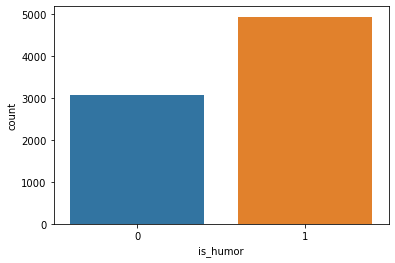

In [49]:
sb.countplot(x='is_humor', data=train_dataset)

In [50]:
sb.countplot(x='humor_rating', order=[1,2,3,4,5], data=train_dataset)

ValueError: Could not interpret input 'humor_rating'

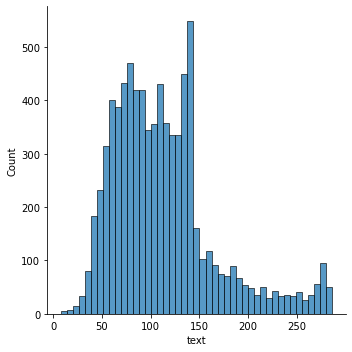

In [51]:
train_len = train_dataset['text'].apply(len)
sb.displot(train_len)

## Preprocessing the data

[[ go back to the top ]](#Table-of-contents)

Now, we will do some tasks needed before applying machine learning algorithms:
1. Clean the 'text' column, by removing non-alphanumeric characters;
2. Lowercase and tokenize it;
3. Stem and remove all stopwords;
4. Create bag-of-words model.

For that, we will present 3 stemming techniques and lemmatization.

### Porter Stemming

This preprocessing technique is known as one of the simplest and fastest, commonly used in Information Retrieval systems research, where the experiments need to be exactly repeatable.

In [52]:
def porterStemming(dataset):
    corpus = []
    ps = PorterStemmer()

    for i in range(0, dataset.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)
    
    return corpus

ps = porterStemming(train_dataset)
ps_test = porterStemming(test_dataset)
print(ps_test)


['find ex got fat like find buck pocket life chang definit put smile face', 'brockmann stereotyp imperil nation secur real threat go unnot racial muslim stigmat violent fanat moreov claim posit well neg stereotyp prevent intimaci love flourish', 'girl run mother pile crap hand look almost step', 'gotta wonder basebal still would call america pastim candi crush around', 'dread get shower cuz lazi get like home', 'parenthood feel like magic unicorn fire eat food', 'friday night control get bit wild tonight cuz put good pajama eat froot loop couch fluffi blanket', 'know hibachi restaur waiter throw shrimp like face', 'mayb need turn unit state back', 'ask north korean friend said complain', 'karaok crowd dig thing friend throw cue worri', 'us straight queer muscular fat tall short twink bear larg small pierc hairi slim domin submiss hiv poz neg brother let discrimin among alreadi suffer discrimin', 'learn turn self doubt energi sourc metabol fear result produc adrenalin wednesday wisdom',

### Snowball Stemming

This technique can support other languages, that's why it's called a multi-lingual stemmer. This stemmer is based on a programming language called ‘Snowball’ that processes small strings and is the most widely used stemmer. The Snowball stemmer is way more aggressive than Porter Stemmer and is also referred to as Porter2 Stemmer. Because of the improvements added when compared to the Porter Stemmer, the Snowball stemmer is having greater computational speed. 

In [53]:
def snowballStemming(dataset):
    corpus = []
    ss = SnowballStemmer(language='english')

    for i in range(0, dataset.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ss.stem(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)

    return corpus

### Lancaster Stemming

The Lancaster stemmers are more aggressive and dynamic compared to the other two stemmers. The stemmer is really faster, but the algorithm is really confusing when dealing with small words. But they are not as efficient as Snowball Stemmers. The Lancaster stemmers save the rules externally and basically uses an iterative algorithm. 

In [54]:
def lancasterStemming(dataset):
    corpus = []
    ls = LancasterStemmer()

    for i in range(0, dataset.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ls.stem(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)
        
    return corpus

### Lemmatization

> Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [55]:
def lemmatization(dataset):
    corpus = []
    wnl = WordNetLemmatizer()

    for i in range(0, dataset.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([wnl.lemmatize(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)

    return corpus

### Stemming or Lemmatization?

One thing to note about lemmatization is that it is harder to create a lemmatizer in a new language than if it is a stemming algorithm because we require a lot more knowledge about structure of a language in lemmatizers.

Stemming and Lemmatization both generate the foundation sort of the inflected words and therefore the only difference is that stem may not be an actual word whereas, lemma is an actual language word.

Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used a corpus also to supply lemma which makes it slower than stemming. you furthermore might had to define a parts-of-speech to get the proper lemma.

This means that:
- **If speed is key, then stemming should be used**, since lemmatizers scan a corpus which consumes time and processing;
- **If you have time and want even better results, then lemmatizing should be used**.

### Bag of words Model

In [56]:
def bagOfWords(corpus, dataset):
    vectorizer = CountVectorizer(max_features = 1500)
    x = vectorizer.fit_transform(corpus).toarray()
    y = dataset.iloc[:,-1].values
    print(y)
    print(x.shape, y.shape)
    return x, y
bow_ps_x, bow_ps_y = bagOfWords(ps, train_dataset)
bow_ps_test_x, bow_ps_test_y = bagOfWords(ps_test, test_dataset)

[1 1 1 ... 1 1 0]
(8000, 1500) (8000,)
[1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0
 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0
 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0
 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0
 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 

## Applying machine learning algorithms

[[ go back to the top ]](#Table-of-contents)

We are planning on implementing at least 3 of the following machine learning algorithms:
- **Naïve Bayes**
- **Decision Trees**
- Neural Networks
- K-NN
- **SVM**


### Naïve Bayes

Description: TODO

In [57]:
def naiveBayes(X_train, y_train, X_test):
    classifier = GaussianNB()
    print(y_train)
    model = classifier.fit(np.array(X_train), np.array(y_train))

    y_pred = classifier.predict(X_test)
    return y_pred

print(bow_ps_y)
nb = naiveBayes(bow_ps_x, bow_ps_y, bow_ps_test_x)
print(nb)

[1 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]
[0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0
 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0
 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0
 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0
 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1
 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1
 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0
 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1
 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1
 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1

## Performance

[[ go back to the top ]](#Table-of-contents)

TO DO

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 

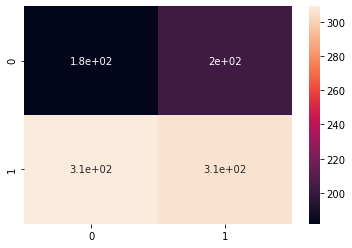

In [60]:
def performance(y_test, y_pred):

    sb.heatmap(confusion_matrix(y_test, y_pred), annot=True)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
print(list(bow_ps_test_y))
print(y_pred)
performance(bow_ps_test_y, y_pred)

### Naïve Bayes with Porter Stemmer

[1 1 1 ... 1 1 0]
(8000, 1500) (8000,)
[1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0
 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0
 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0
 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0
 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 

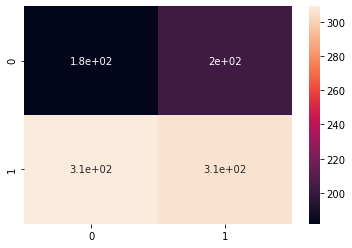

In [61]:
corpus_train = porterStemming(train_dataset)
corpus_test = porterStemming(test_dataset)

train_x, train_y = bagOfWords(corpus_train, train_dataset)
test_x, test_y = bagOfWords(corpus_test, test_dataset)

y_pred = naiveBayes(train_x, train_y, test_x)
performance(bow_ps_test_y, nb)

## Conclusions

[[ go back to the top ]](#Table-of-contents)

TO DO

## References

[[ go back to the top ]](#Table-of-contents)

TO DO